In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.metrics import Recall

# Load the dataset
file_path = 'diabetes.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
df.head()

2024-10-04 15:55:57.986439: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
# Displaying basic statistics of the dataset
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.shape

(768, 9)

In [5]:
 df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

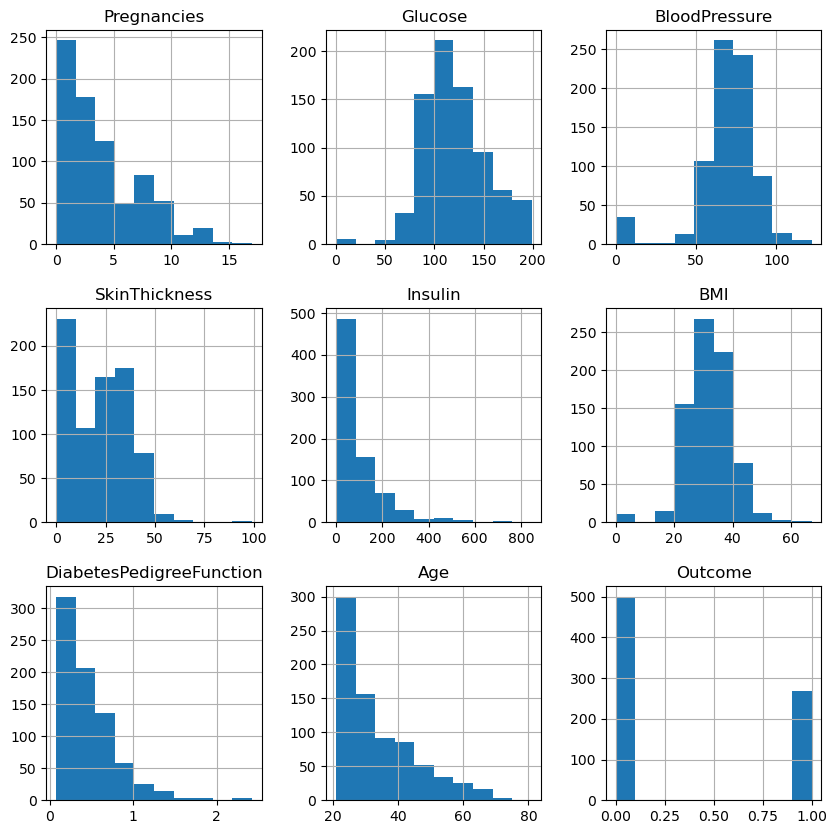

In [6]:
# View the distributioh each columns from the data
df.hist(figsize=(10,10))

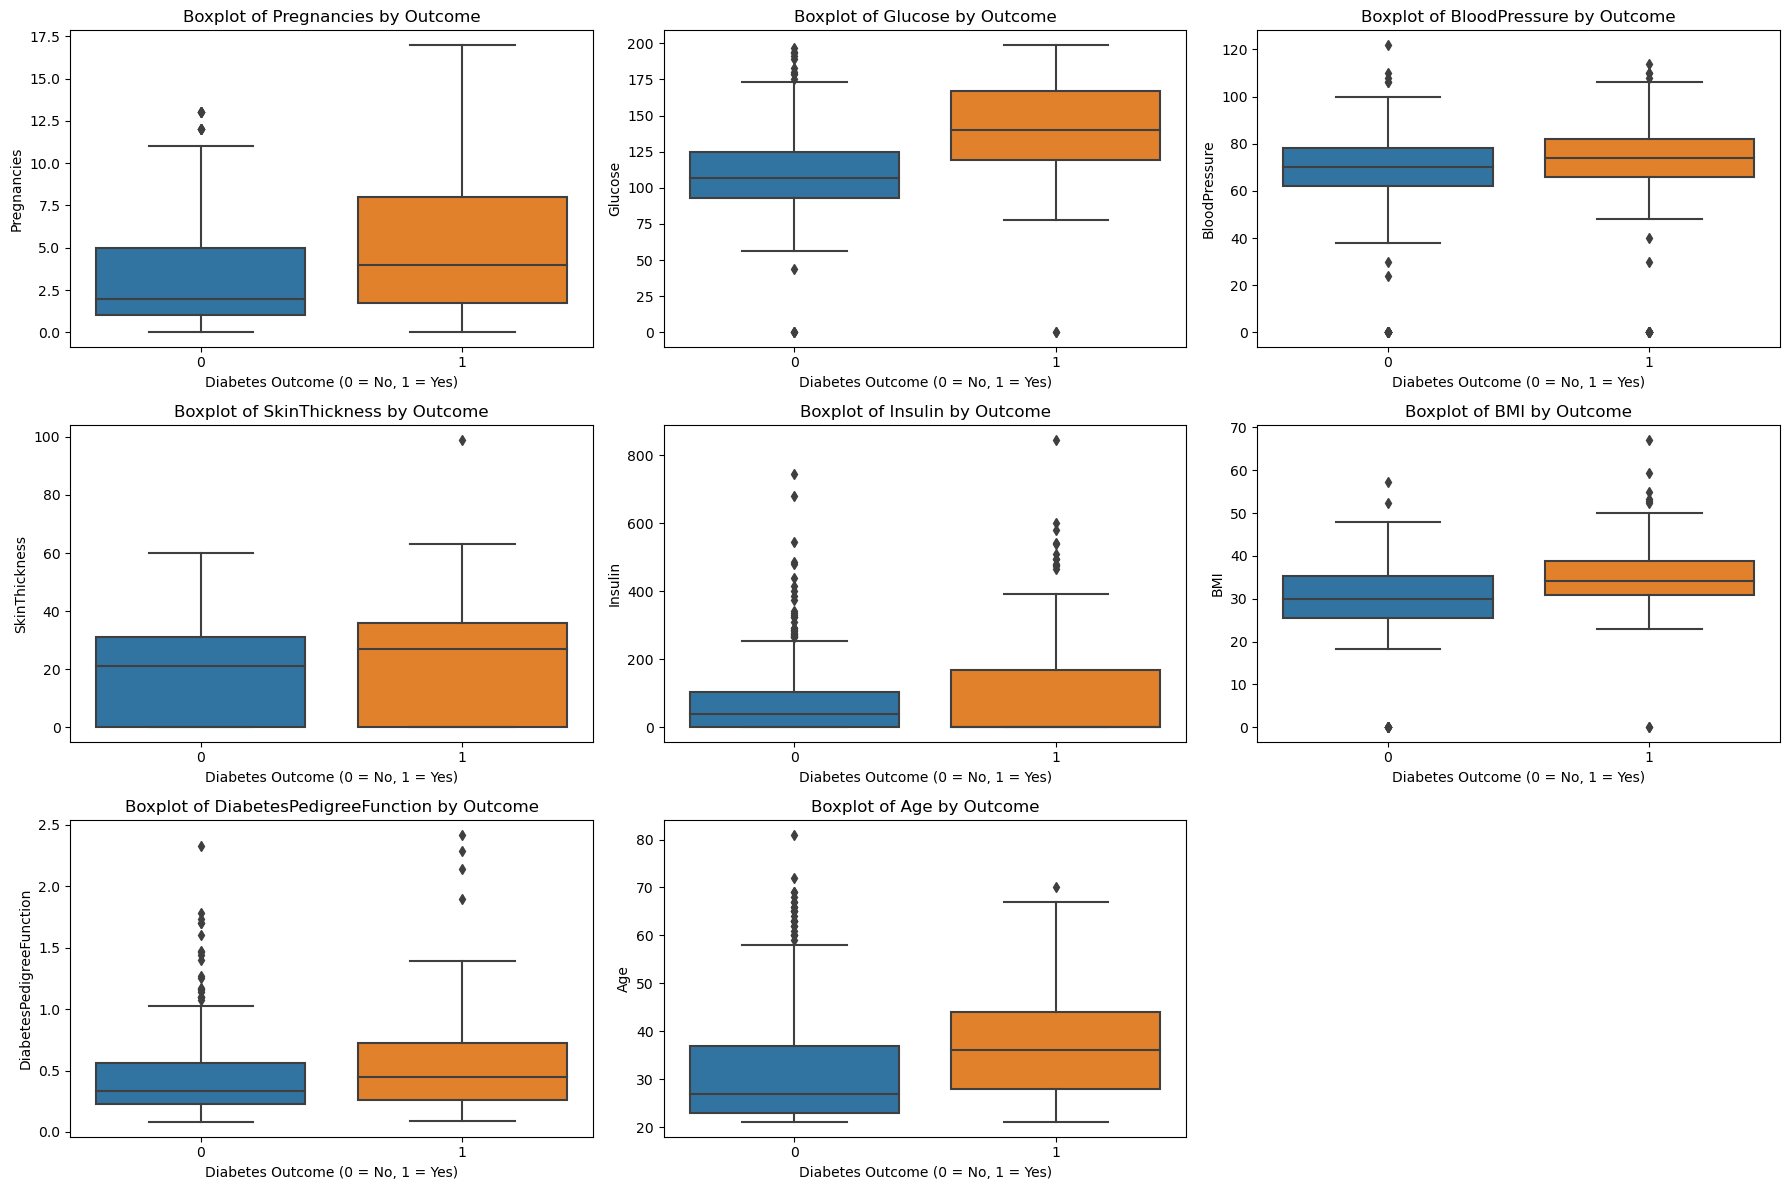

In [7]:
# Create boxplots for selected features to compare Outcome (Diabetes = 1, No Diabetes = 0)
plt.figure(figsize=(18, 12))

# Loop through numerical features and create boxplots
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)  # Adjusted to 3 rows and 3 columns
    sns.boxplot(x='Outcome', y=feature, data=df)
    plt.title(f'Boxplot of {feature} by Outcome')
    plt.xlabel('Diabetes Outcome (0 = No, 1 = Yes)')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


From the histogram and boxplot, I can see a lot of outliers and potentially invalid data. But, for now, I decided to only change the invalid values in BMI since I found a reference that recorded the lowest BMI in Anorexia nervosa studies was 6.7 kg/m2. So, I assumed the 0 values in BMI was invalid and I changed it with median value of BMI. On the other hand, I will keep the others since I do not have any expertise or references to validate the data.

In [8]:
# Columns to check
columns_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Count the number of zeros in the specified columns
zero_counts = (df[columns_to_check] == 0).sum()

# Display the result
print('Number of 0 value in each column that need further investigation:')
print(zero_counts)

# Change the 0 values in BMI with median
median_bmi = df.loc[df['BMI'] != 0, 'BMI'].median()
df['BMI'] = df['BMI'].replace(0, median_bmi)

print()
print('After change 0 values in BMI:')
# Count the number of zeros in the specified columns
zero_counts = (df[columns_to_check] == 0).sum()
zero_counts

Number of 0 value in each column that need further investigation:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

After change 0 values in BMI:


Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI                0
dtype: int64

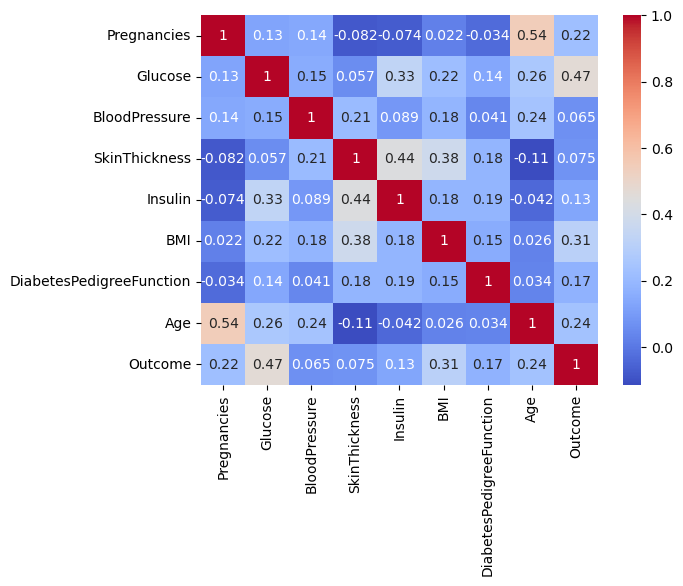

In [9]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

# Preprocessing

Because some features have different scales (for example, glucose levels can be much greater than skin thickness), I need to perform standardization or normalization for a better performance.

In [10]:
# Do standard scaling
scaler = StandardScaler()
features = df.drop(columns='Outcome')
scaled_features = scaler.fit_transform(features)

# Split the data into two part, X for the features and y for the target/label
X = pd.DataFrame(scaled_features, columns=features.columns)
y = df['Outcome']

from sklearn.model_selection import train_test_split
# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(scaled_features, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((460, 8), (460,), (154, 8), (154,), (154, 8), (154,))

In [11]:
def create_SLP(activation=None, optimizer='adam', learning_rate=0.01, loss='binary_crossentropy'):
    model = Sequential()
    model.add(Dense(1, 
                    input_dim=X_train.shape[1], 
                    activation=activation))  # User-defined activation function
    
    # Set optimizer based on user input
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer. Choose 'adam', 'rmsprop', or 'sgd'.")
    
    # Compile the model with user-specified loss function and optimizer
    model.compile(optimizer=opt, 
                  loss=loss, 
                  metrics=['accuracy'])  # User-defined optimizer, learning rate, and loss
    
    return model

In [12]:
def train_SLP(model, epochs=100, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   #patience=patience, 
                                   restore_best_weights=True)
    model.summary()
    history = model.fit(X_train, y_train, 
                              epochs=epochs, 
                              validation_data=(X_val, y_val), 
                              batch_size=batch_size, 
                              verbose=0)#, 
                              #callbacks=[early_stopping])
    return history

In [13]:
def plot_training_history(history):

# Extract accuracy and loss values from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    # Get best epoch metrics
    best_epoch_acc = np.argmax(val_acc) + 1
    best_val_acc = val_acc[best_epoch_acc - 1] * 100

    best_epoch_loss = np.argmin(val_loss) + 1
    best_val_loss = val_loss[best_epoch_loss - 1]

    # Run summary
    print("\033[1mRun summary\033[0m")
    print(f"Final Training Accuracy: {acc[-1] * 100:.2f}%")
    print(f"Final Training Loss: {loss[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_acc[-1] * 100:.2f}%")
    print(f"Final Validation Loss: {val_loss[-1]:.4f}")
    print(f"Best Epoch for Validation Accuracy: Epoch {best_epoch_acc} with Validation Accuracy {best_val_acc:.2f}%")
    print(f"Best Epoch for Validation Loss: Epoch {best_epoch_loss} with Validation Loss {best_val_loss:.4f}")

# Baseline Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


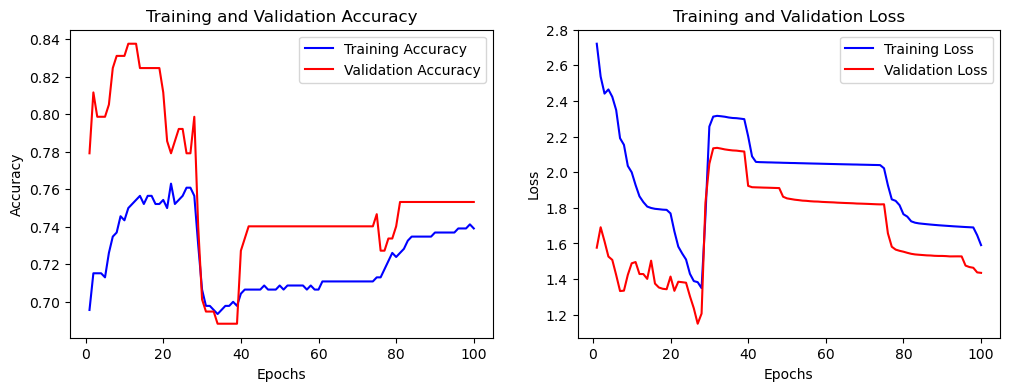

Run summary
Final Training Accuracy: 73.91%
Final Training Loss: 1.5906
Final Validation Accuracy: 75.32%
Final Validation Loss: 1.4349
Best Epoch for Validation Accuracy: Epoch 11 with Validation Accuracy 83.77%
Best Epoch for Validation Loss: Epoch 27 with Validation Loss 1.1492


In [14]:
baseline = create_SLP(activation=None,  
                    optimizer='adam', 
                    learning_rate=0.01, 
                    loss='binary_crossentropy')

baseline_history = train_SLP(model=baseline, 
                           epochs=100, 
                           batch_size=32)

plot_training_history(baseline_history)

# Experiments

# Single layer perceptron (SLP) with sigmoid activation function.

# Adam

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


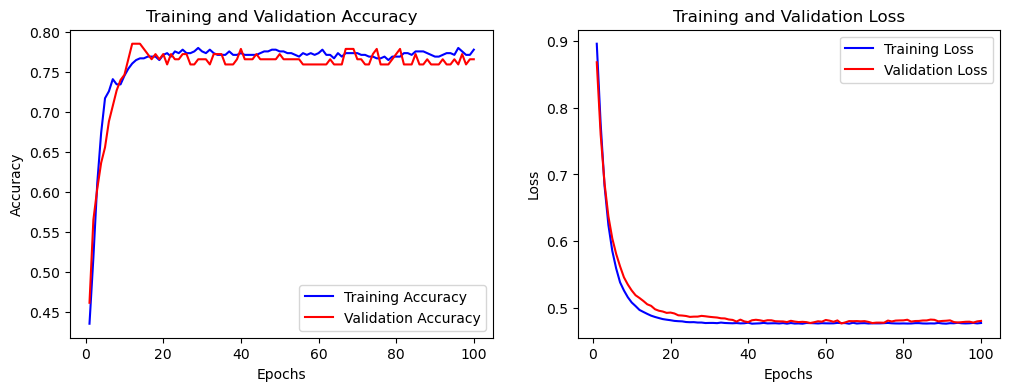

Run summary
Final Training Accuracy: 77.83%
Final Training Loss: 0.4768
Final Validation Accuracy: 76.62%
Final Validation Loss: 0.4800
Best Epoch for Validation Accuracy: Epoch 12 with Validation Accuracy 78.57%
Best Epoch for Validation Loss: Epoch 64 with Validation Loss 0.4762


In [16]:
model1 = create_SLP(activation='sigmoid', 
                    optimizer='adam', 
                    learning_rate=0.01, 
                    loss='binary_crossentropy')

model1_history=train_SLP(model=model1, 
                         epochs=100, 
                         batch_size=32)

plot_training_history(model1_history)

# RMSprop

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


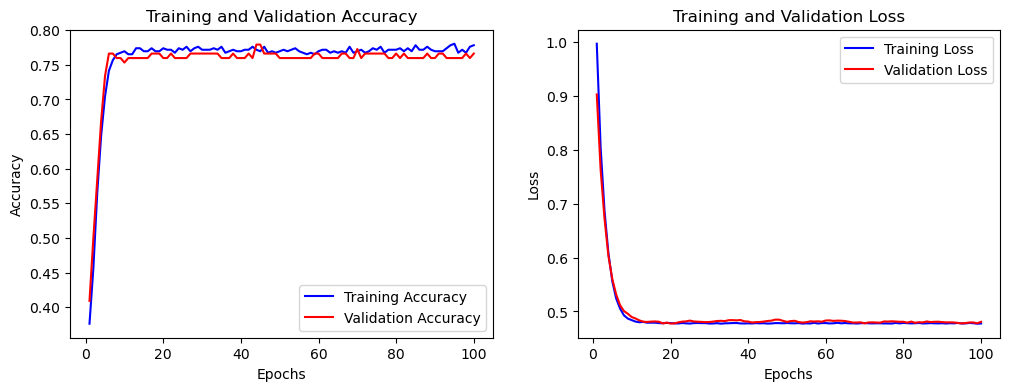

Run summary
Final Training Accuracy: 77.83%
Final Training Loss: 0.4777
Final Validation Accuracy: 76.62%
Final Validation Loss: 0.4808
Best Epoch for Validation Accuracy: Epoch 44 with Validation Accuracy 77.92%
Best Epoch for Validation Loss: Epoch 20 with Validation Loss 0.4776


In [17]:
model2 = create_SLP(activation='sigmoid', 
                    optimizer='rmsprop', 
                    learning_rate=0.01, 
                    loss='binary_crossentropy')

model2_history=train_SLP(model=model2, 
                         epochs=100, 
                         batch_size=32)

plot_training_history(model2_history)

# SGD

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


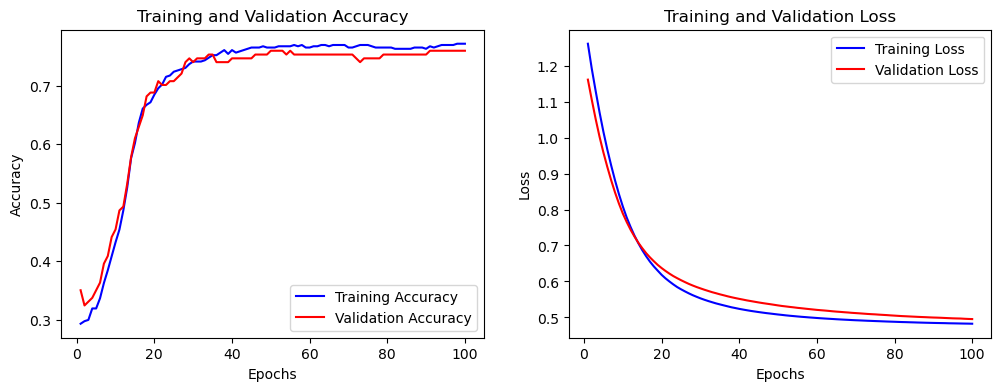

Run summary
Final Training Accuracy: 77.17%
Final Training Loss: 0.4824
Final Validation Accuracy: 75.97%
Final Validation Loss: 0.4953
Best Epoch for Validation Accuracy: Epoch 50 with Validation Accuracy 75.97%
Best Epoch for Validation Loss: Epoch 100 with Validation Loss 0.4953


In [18]:
model3 = create_SLP(activation='sigmoid', 
                    optimizer='sgd', 
                    learning_rate=0.01, 
                    loss='binary_crossentropy')

model3_history=train_SLP(model=model3, 
                         epochs=100, 
                         batch_size=32)

plot_training_history(model3_history)

# Learning rate = 0.001

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


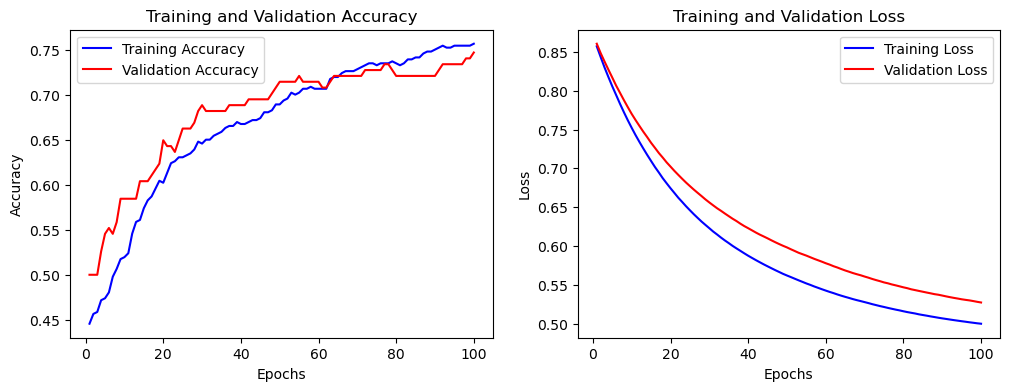

Run summary
Final Training Accuracy: 75.65%
Final Training Loss: 0.5000
Final Validation Accuracy: 74.68%
Final Validation Loss: 0.5274
Best Epoch for Validation Accuracy: Epoch 100 with Validation Accuracy 74.68%
Best Epoch for Validation Loss: Epoch 100 with Validation Loss 0.5274


In [19]:
model4 = create_SLP(activation='sigmoid', 
                    optimizer='adam', 
                    learning_rate=0.001, 
                    loss='binary_crossentropy')

model4_history=train_SLP(model=model4, 
                         epochs=100, 
                         batch_size=32)

plot_training_history(model4_history)

# Learning rate = 0.005

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


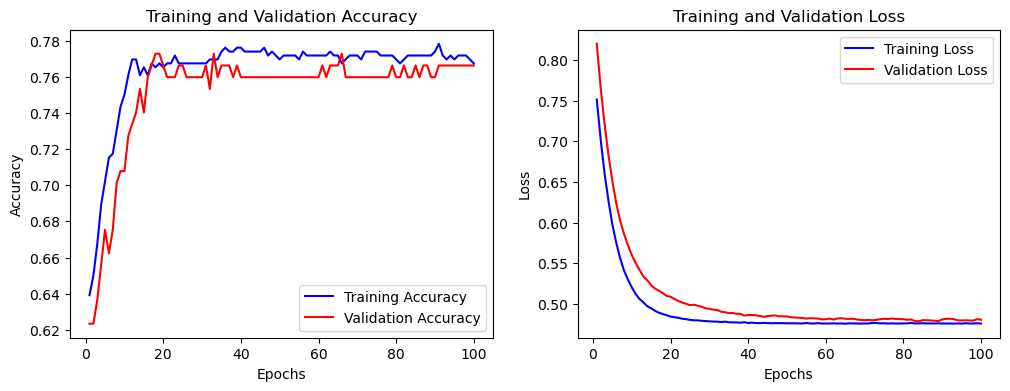

Run summary
Final Training Accuracy: 76.74%
Final Training Loss: 0.4756
Final Validation Accuracy: 76.62%
Final Validation Loss: 0.4803
Best Epoch for Validation Accuracy: Epoch 18 with Validation Accuracy 77.27%
Best Epoch for Validation Loss: Epoch 84 with Validation Loss 0.4785


In [20]:
model5 = create_SLP(activation='sigmoid', 
                    optimizer='adam', 
                    learning_rate=0.005, 
                    loss='binary_crossentropy')

model5_history=train_SLP(model=model5, 
                         epochs=100, 
                         batch_size=32)

plot_training_history(model5_history)

# Learning rate = 0.05

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


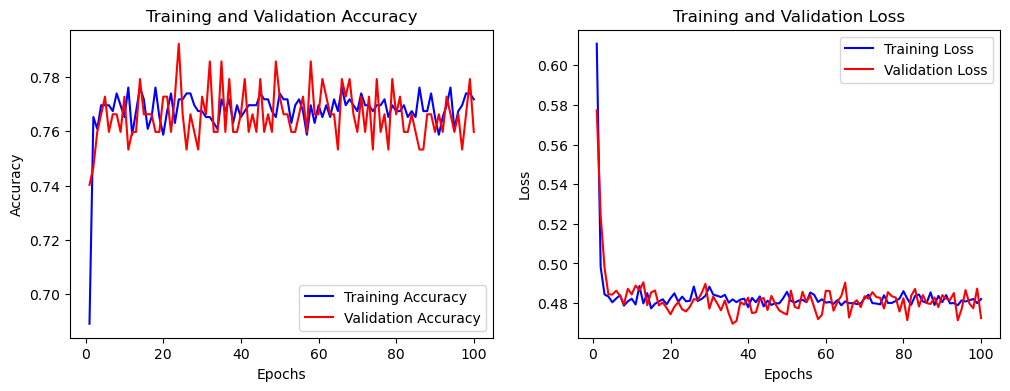

Run summary
Final Training Accuracy: 77.17%
Final Training Loss: 0.4820
Final Validation Accuracy: 75.97%
Final Validation Loss: 0.4724
Best Epoch for Validation Accuracy: Epoch 24 with Validation Accuracy 79.22%
Best Epoch for Validation Loss: Epoch 36 with Validation Loss 0.4695


In [21]:
model6 = create_SLP(activation='sigmoid', 
                    optimizer='adam', 
                    learning_rate=0.05, 
                    loss='binary_crossentropy')

model6_history=train_SLP(model=model6, 
                         epochs=100, 
                         batch_size=32)

plot_training_history(model6_history)

# Learning rate = 0.1

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


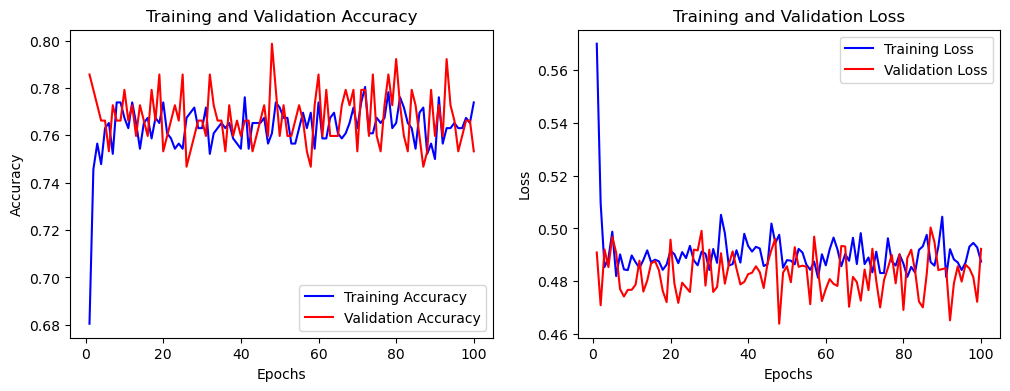

Run summary
Final Training Accuracy: 77.39%
Final Training Loss: 0.4874
Final Validation Accuracy: 75.32%
Final Validation Loss: 0.4922
Best Epoch for Validation Accuracy: Epoch 48 with Validation Accuracy 79.87%
Best Epoch for Validation Loss: Epoch 48 with Validation Loss 0.4638


In [22]:
model7 = create_SLP(activation='sigmoid', 
                    optimizer='adam', 
                    learning_rate=0.1, 
                    loss='binary_crossentropy')

model7_history=train_SLP(model=model7, 
                         epochs=100, 
                         batch_size=32)

plot_training_history(model7_history)

# Learning rate = 0.5

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


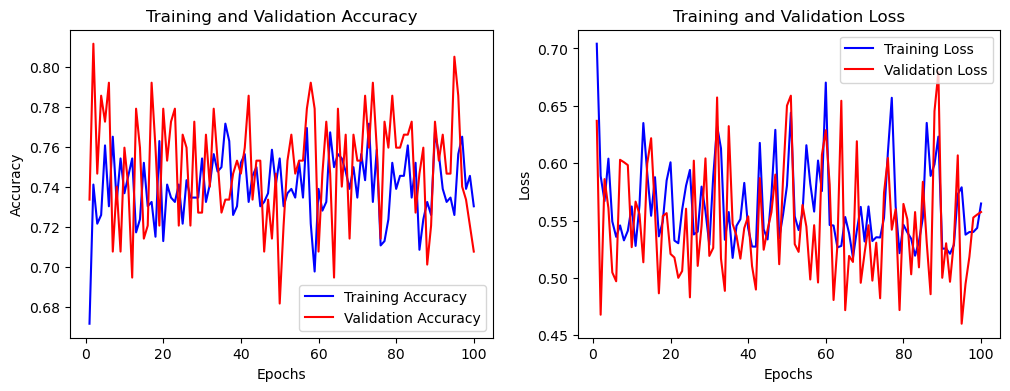

Run summary
Final Training Accuracy: 73.04%
Final Training Loss: 0.5648
Final Validation Accuracy: 70.78%
Final Validation Loss: 0.5574
Best Epoch for Validation Accuracy: Epoch 2 with Validation Accuracy 81.17%
Best Epoch for Validation Loss: Epoch 95 with Validation Loss 0.4600


In [23]:
model8 = create_SLP(activation='sigmoid', 
                    optimizer='adam', 
                    learning_rate=0.5, 
                    loss='binary_crossentropy')

model8_history=train_SLP(model=model8, 
                         epochs=100, 
                         batch_size=32)

plot_training_history(model8_history)

# epochs 50, Learning rate = 0.01

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


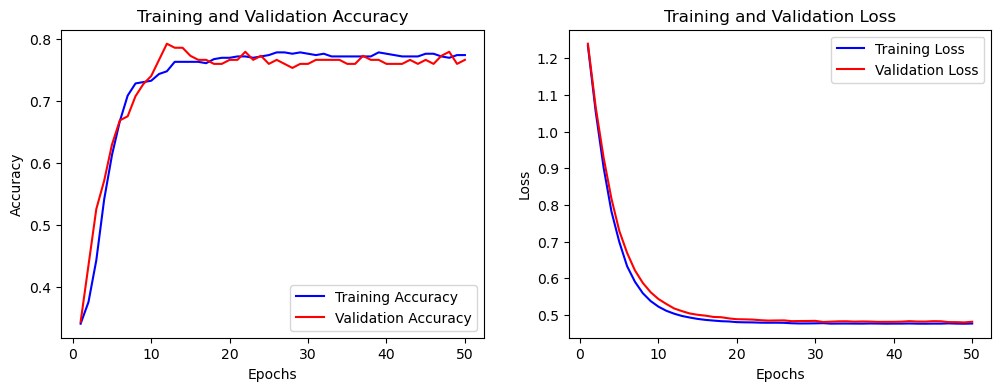

Run summary
Final Training Accuracy: 77.39%
Final Training Loss: 0.4767
Final Validation Accuracy: 76.62%
Final Validation Loss: 0.4815
Best Epoch for Validation Accuracy: Epoch 12 with Validation Accuracy 79.22%
Best Epoch for Validation Loss: Epoch 49 with Validation Loss 0.4797


In [25]:
model9 = create_SLP(activation='sigmoid', 
                    optimizer='adam', 
                    learning_rate=0.01, 
                    loss='binary_crossentropy')

model9_history=train_SLP(model=model9, 
                         epochs=50, 
                         batch_size=32)

plot_training_history(model9_history)

# epochs 150, Learning rate = 0.01

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


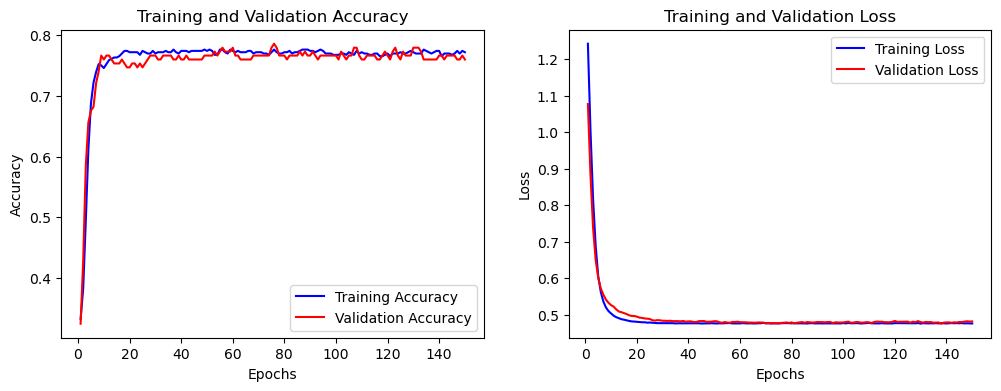

Run summary
Final Training Accuracy: 77.17%
Final Training Loss: 0.4759
Final Validation Accuracy: 75.97%
Final Validation Loss: 0.4815
Best Epoch for Validation Accuracy: Epoch 76 with Validation Accuracy 78.57%
Best Epoch for Validation Loss: Epoch 138 with Validation Loss 0.4752


In [26]:
model10 = create_SLP(activation='sigmoid', 
                    optimizer='adam', 
                    learning_rate=0.01, 
                    loss='binary_crossentropy')

model10_history=train_SLP(model=model10, 
                         epochs=150, 
                         batch_size=32)

plot_training_history(model10_history)

# epochs 50, Learning rate = 0.005

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


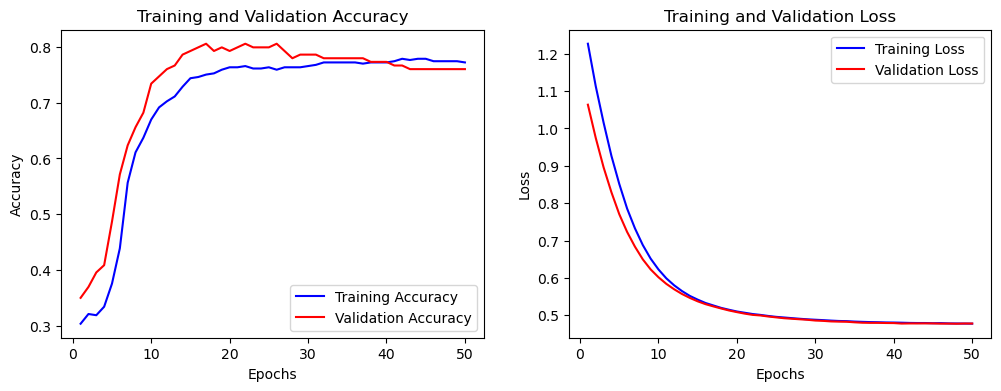

Run summary
Final Training Accuracy: 77.17%
Final Training Loss: 0.4774
Final Validation Accuracy: 75.97%
Final Validation Loss: 0.4777
Best Epoch for Validation Accuracy: Epoch 17 with Validation Accuracy 80.52%
Best Epoch for Validation Loss: Epoch 48 with Validation Loss 0.4772


In [27]:
model11 = create_SLP(activation='sigmoid', 
                    optimizer='adam', 
                    learning_rate=0.005, 
                    loss='binary_crossentropy')

model11_history=train_SLP(model=model11, 
                         epochs=50, 
                         batch_size=32)

plot_training_history(model11_history)

# epochs 150, Learning rate = 0.005

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


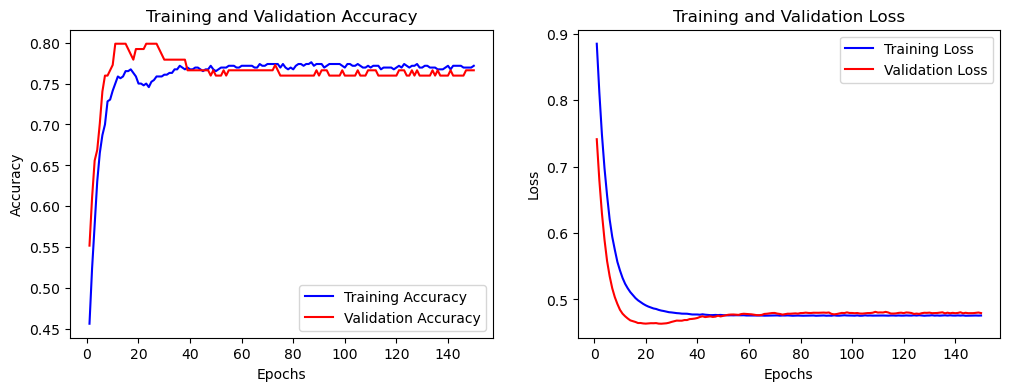

Run summary
Final Training Accuracy: 77.17%
Final Training Loss: 0.4758
Final Validation Accuracy: 76.62%
Final Validation Loss: 0.4795
Best Epoch for Validation Accuracy: Epoch 11 with Validation Accuracy 79.87%
Best Epoch for Validation Loss: Epoch 26 with Validation Loss 0.4635


In [28]:
model12 = create_SLP(activation='sigmoid', 
                    optimizer='adam', 
                    learning_rate=0.005, 
                    loss='binary_crossentropy')

model12_history=train_SLP(model=model12, 
                         epochs=150, 
                         batch_size=32)

plot_training_history(model12_history)

# With early stopping, Learning rate = 0.01, Patience = 5

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


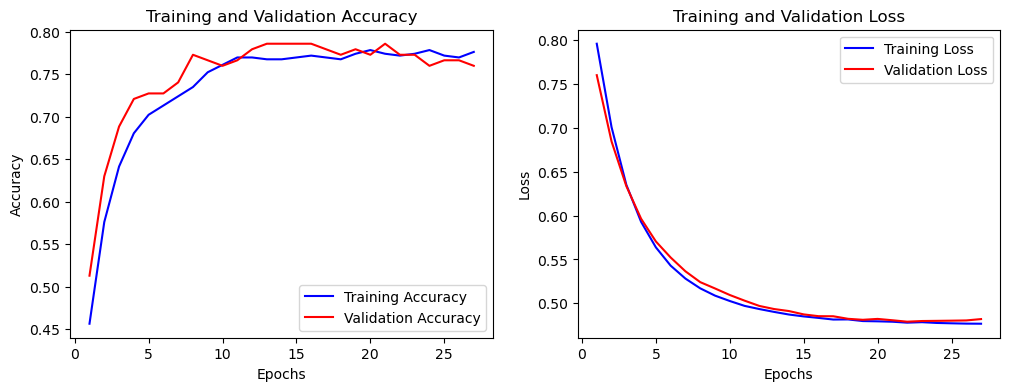

Run summary
Final Training Accuracy: 77.61%
Final Training Loss: 0.4767
Final Validation Accuracy: 75.97%
Final Validation Loss: 0.4820
Best Epoch for Validation Accuracy: Epoch 13 with Validation Accuracy 78.57%
Best Epoch for Validation Loss: Epoch 22 with Validation Loss 0.4790


In [29]:
def train_SLP_early_stopping(model, patience=5, epochs=100, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   patience=patience, 
                                   restore_best_weights=True)
    model.summary()
    history = model.fit(X_train, y_train, 
                              epochs=epochs, 
                              validation_data=(X_val, y_val), 
                              batch_size=batch_size, 
                              verbose=0, 
                              callbacks=[early_stopping])
    return history

model13 = create_SLP(activation='sigmoid', 
                    optimizer='adam', 
                    learning_rate=0.01, 
                    loss='binary_crossentropy')

model13_history=train_SLP_early_stopping(model=model13,
                         patience=5,
                         epochs=50, 
                         batch_size=32)

plot_training_history(model13_history)

# With early stopping, Learning rate = 0.01, Patience = 10

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


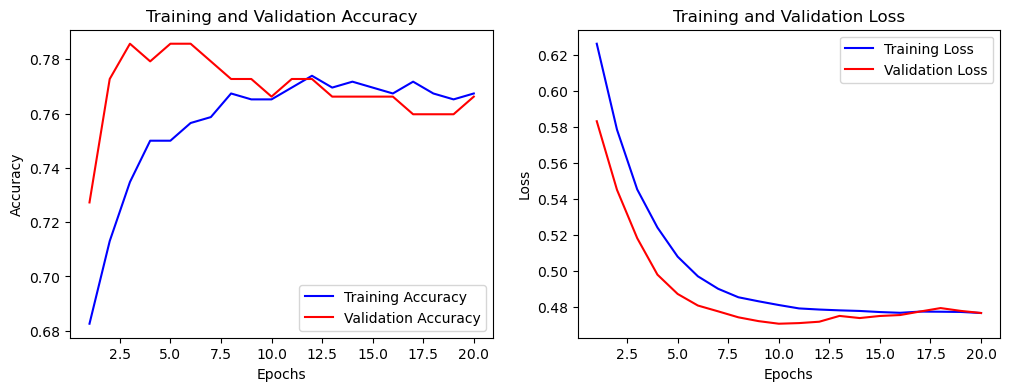

Run summary
Final Training Accuracy: 76.74%
Final Training Loss: 0.4764
Final Validation Accuracy: 76.62%
Final Validation Loss: 0.4764
Best Epoch for Validation Accuracy: Epoch 3 with Validation Accuracy 78.57%
Best Epoch for Validation Loss: Epoch 10 with Validation Loss 0.4704


In [31]:
model14 = create_SLP(activation='sigmoid', 
                    optimizer='adam', 
                    learning_rate=0.01, 
                    loss='binary_crossentropy')

model14_history=train_SLP_early_stopping(model=model14, 
                         patience=10, 
                         epochs=50, 
                         batch_size=32)

plot_training_history(model14_history)

# With early stopping, Learning rate = 0.005, Patience = 5

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


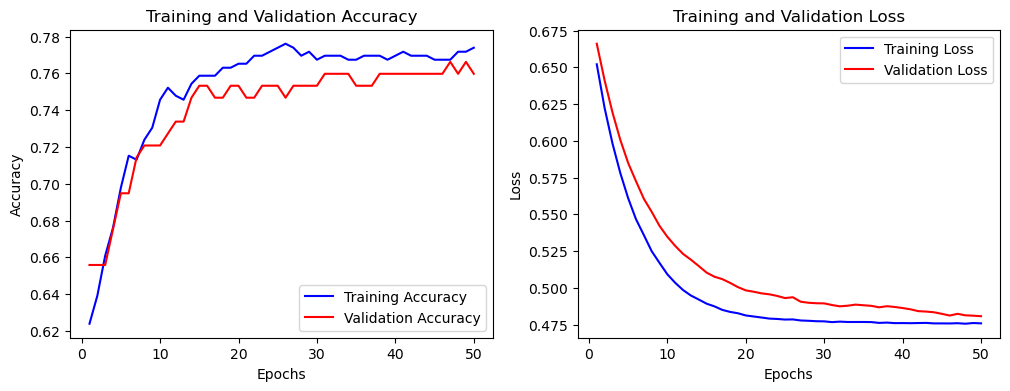

Run summary
Final Training Accuracy: 77.39%
Final Training Loss: 0.4758
Final Validation Accuracy: 75.97%
Final Validation Loss: 0.4807
Best Epoch for Validation Accuracy: Epoch 47 with Validation Accuracy 76.62%
Best Epoch for Validation Loss: Epoch 50 with Validation Loss 0.4807


In [32]:
model15 = create_SLP(activation='sigmoid', 
                    optimizer='adam', 
                    learning_rate=0.005, 
                    loss='binary_crossentropy')

model15_history=train_SLP_early_stopping(model=model15,
                         patience=5,
                         epochs=50, 
                         batch_size=32)

plot_training_history(model15_history)

# With early stopping, Learning rate = 0.005, Patience = 10

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


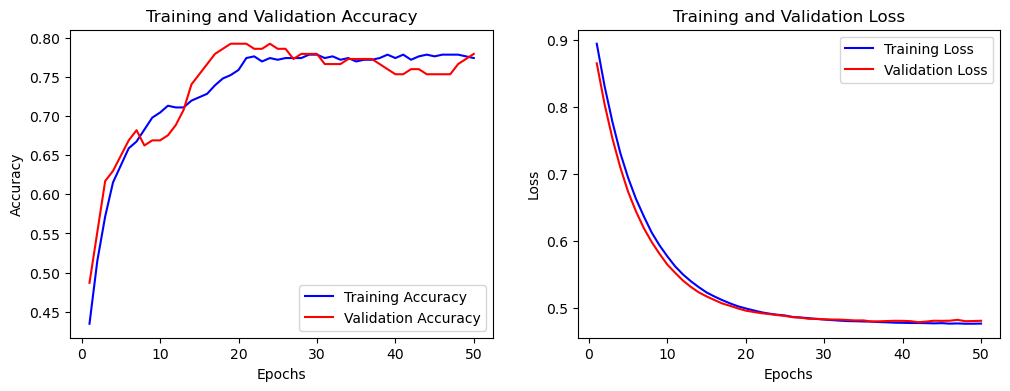

Run summary
Final Training Accuracy: 77.39%
Final Training Loss: 0.4770
Final Validation Accuracy: 77.92%
Final Validation Loss: 0.4812
Best Epoch for Validation Accuracy: Epoch 19 with Validation Accuracy 79.22%
Best Epoch for Validation Loss: Epoch 42 with Validation Loss 0.4791


In [33]:
model16 = create_SLP(activation='sigmoid', 
                    optimizer='adam', 
                    learning_rate=0.005, 
                    loss='binary_crossentropy')

model16_history=train_SLP_early_stopping(model=model16,
                         patience=10,
                         epochs=50, 
                         batch_size=32)

plot_training_history(model16_history)

# Batch = 16, With early stopping, Learning rate = 0.005, Patience = 10

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


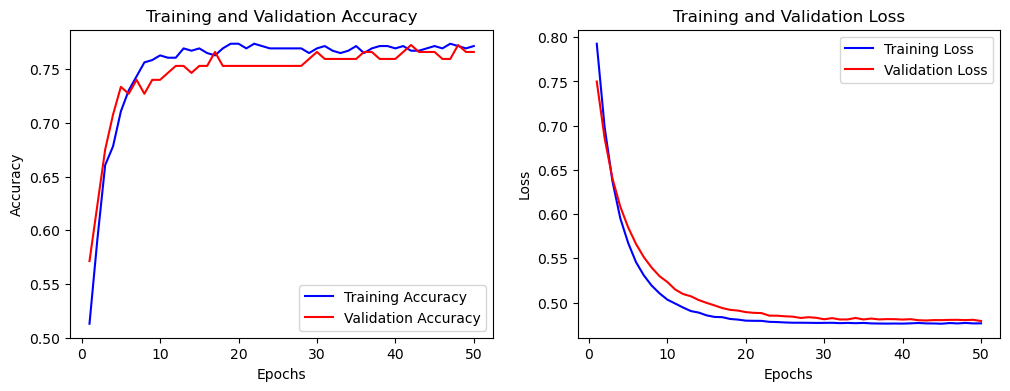

Run summary
Final Training Accuracy: 77.17%
Final Training Loss: 0.4765
Final Validation Accuracy: 76.62%
Final Validation Loss: 0.4791
Best Epoch for Validation Accuracy: Epoch 42 with Validation Accuracy 77.27%
Best Epoch for Validation Loss: Epoch 50 with Validation Loss 0.4791


In [34]:
model17 = create_SLP(activation='sigmoid', 
                    optimizer='adam', 
                    learning_rate=0.005, 
                    loss='binary_crossentropy')

model17_history=train_SLP_early_stopping(model=model17,
                         patience=10,
                         epochs=50, 
                         batch_size=16)

plot_training_history(model17_history)

# Batch = 48, With early stopping, Learning rate = 0.005, Patience = 10

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


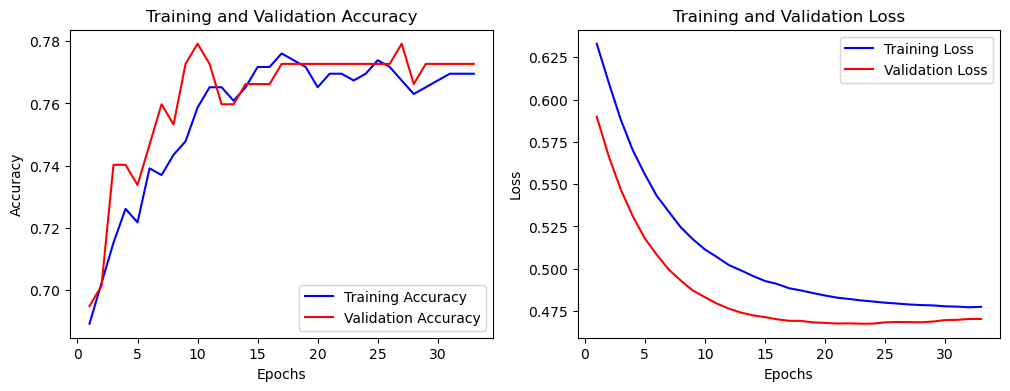

Run summary
Final Training Accuracy: 76.96%
Final Training Loss: 0.4775
Final Validation Accuracy: 77.27%
Final Validation Loss: 0.4703
Best Epoch for Validation Accuracy: Epoch 10 with Validation Accuracy 77.92%
Best Epoch for Validation Loss: Epoch 23 with Validation Loss 0.4675


In [35]:
model18 = create_SLP(activation='sigmoid', 
                    optimizer='adam', 
                    learning_rate=0.005, 
                    loss='binary_crossentropy')

model18_history=train_SLP_early_stopping(model=model18,
                         patience=10,
                         epochs=50, 
                         batch_size=48)

plot_training_history(model18_history)

# Batch = 64, With early stopping, Learning rate = 0.005, Patience = 10

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


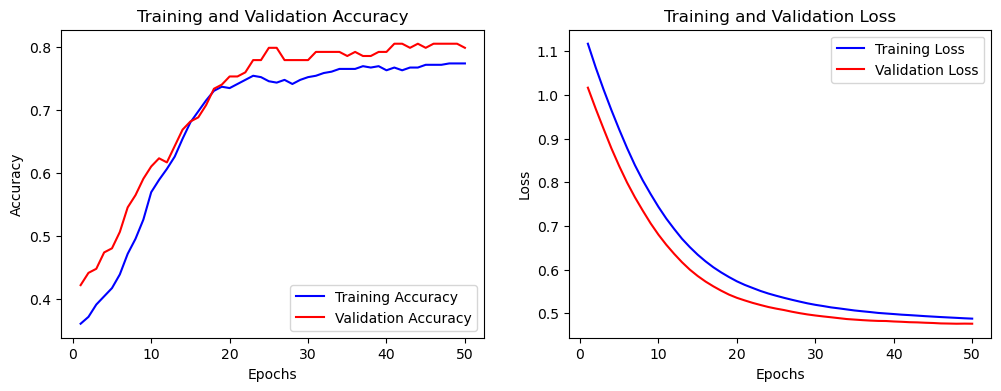

Run summary
Final Training Accuracy: 77.39%
Final Training Loss: 0.4875
Final Validation Accuracy: 79.87%
Final Validation Loss: 0.4759
Best Epoch for Validation Accuracy: Epoch 41 with Validation Accuracy 80.52%
Best Epoch for Validation Loss: Epoch 48 with Validation Loss 0.4758


In [36]:
model19 = create_SLP(activation='sigmoid', 
                    optimizer='adam', 
                    learning_rate=0.005, 
                    loss='binary_crossentropy')

model19_history=train_SLP_early_stopping(model=model19,
                         patience=10,
                         epochs=50, 
                         batch_size=64)

plot_training_history(model19_history)

# batch 48, patience = 10, lr = 0.005, epochs= 50, cw 0:1, 1:2

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


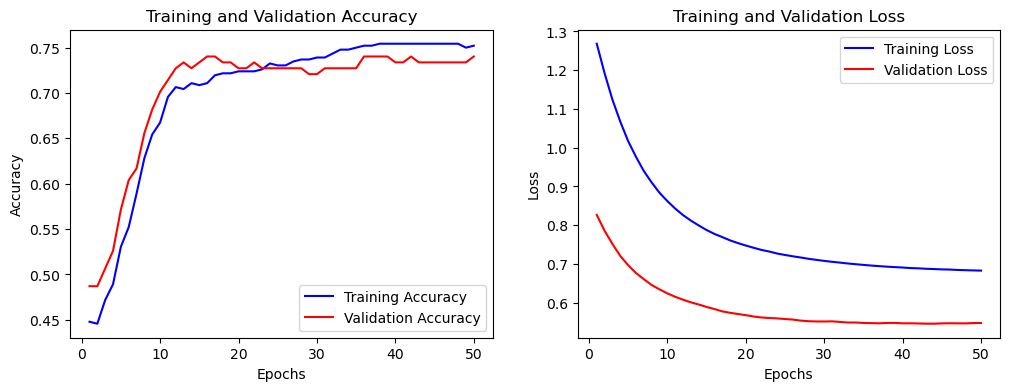

Run summary
Final Training Accuracy: 75.22%
Final Training Loss: 0.6829
Final Validation Accuracy: 74.03%
Final Validation Loss: 0.5478
Best Epoch for Validation Accuracy: Epoch 16 with Validation Accuracy 74.03%
Best Epoch for Validation Loss: Epoch 44 with Validation Loss 0.5459


In [37]:
def train_SLP_cw(model, patience=5, epochs=100, batch_size=32, class_weight={0:1, 1:2}):
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   patience=patience, 
                                   restore_best_weights=True)
    model.summary()
    history = model.fit(X_train, y_train, 
                              epochs=epochs, 
                              validation_data=(X_val, y_val), 
                              batch_size=batch_size, 
                              verbose=0, 
                              class_weight=class_weight,
                              callbacks=[early_stopping])
    return history

model20 = create_SLP(activation='sigmoid', 
                    optimizer='adam', 
                    learning_rate=0.005, 
                    loss='binary_crossentropy')

model20_history=train_SLP_cw(model=model20, 
                         patience=10, 
                         epochs=50, 
                         batch_size=48,
                         class_weight={0:1, 1:2})

plot_training_history(model20_history)

# batch 48, patience = 10, lr = 0.005, epochs= 50, cw 0:1, 1:3

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


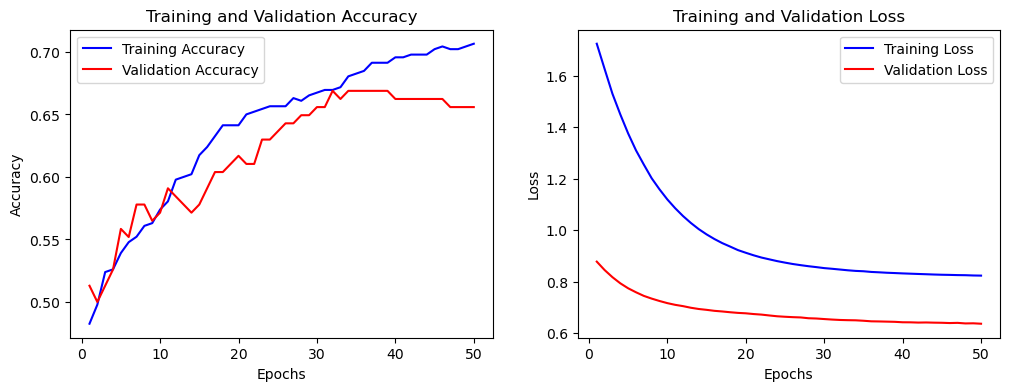

Run summary
Final Training Accuracy: 70.65%
Final Training Loss: 0.8240
Final Validation Accuracy: 65.58%
Final Validation Loss: 0.6372
Best Epoch for Validation Accuracy: Epoch 32 with Validation Accuracy 66.88%
Best Epoch for Validation Loss: Epoch 50 with Validation Loss 0.6372


In [38]:
model21 = create_SLP(activation='sigmoid', 
                    optimizer='adam', 
                    learning_rate=0.005, 
                    loss='binary_crossentropy')

model21_history=train_SLP_cw(model=model21, 
                         patience=10, 
                         epochs=50, 
                         batch_size=48,
                         class_weight={0:1, 1:3})

plot_training_history(model21_history)

# batch 32, patience = 10, lr = 0.005, epochs= 50, cw 0:1, 1:3

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


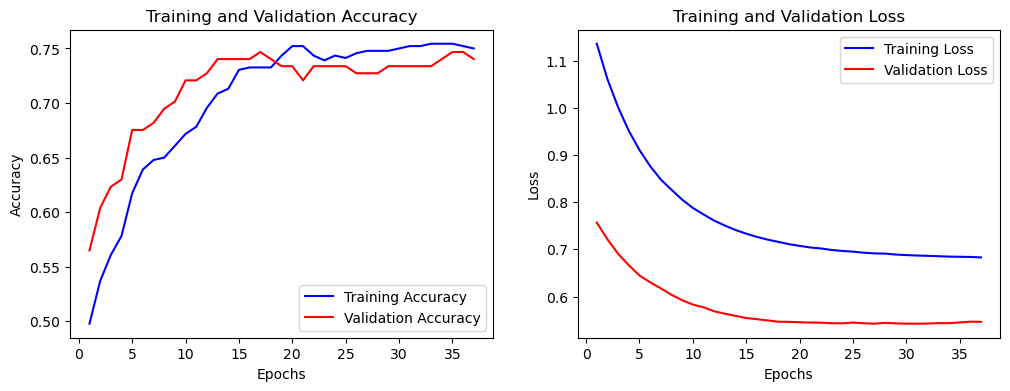

Run summary
Final Training Accuracy: 75.00%
Final Training Loss: 0.6828
Final Validation Accuracy: 74.03%
Final Validation Loss: 0.5463
Best Epoch for Validation Accuracy: Epoch 17 with Validation Accuracy 74.68%
Best Epoch for Validation Loss: Epoch 27 with Validation Loss 0.5423


In [39]:
model22 = create_SLP(activation='sigmoid', 
                    optimizer='adam', 
                    learning_rate=0.005, 
                    loss='binary_crossentropy')

model22_history=train_SLP_cw(model=model22, 
                         patience=10, 
                         epochs=50, 
                         batch_size=32,
                         class_weight={0:1, 1:2})

plot_training_history(model22_history)

# batch 32, patience = 10, lr = 0.005, epochs= 50, cw 0:1, 1:3

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 1)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


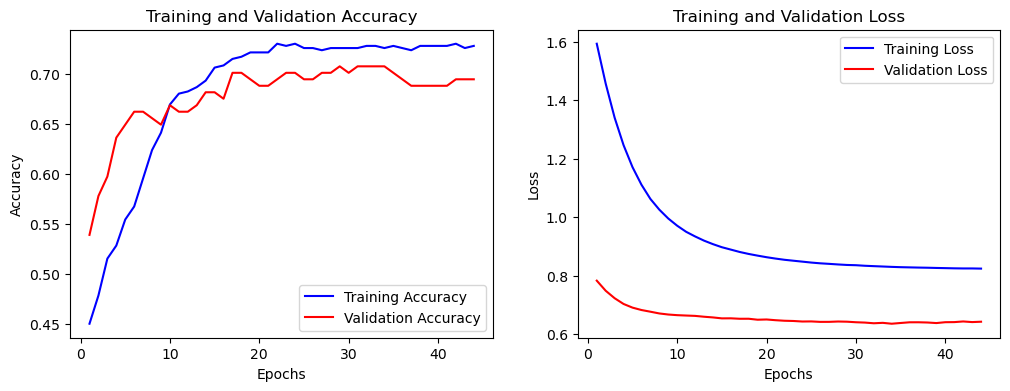

Run summary
Final Training Accuracy: 72.83%
Final Training Loss: 0.8247
Final Validation Accuracy: 69.48%
Final Validation Loss: 0.6433
Best Epoch for Validation Accuracy: Epoch 29 with Validation Accuracy 70.78%
Best Epoch for Validation Loss: Epoch 34 with Validation Loss 0.6364


In [40]:
model23 = create_SLP(activation='sigmoid', 
                    optimizer='adam', 
                    learning_rate=0.005, 
                    loss='binary_crossentropy')

model23_history=train_SLP_cw(model=model23, 
                         patience=10, 
                         epochs=50, 
                         batch_size=32,
                         class_weight={0:1, 1:3})

plot_training_history(model23_history)

# Evaluate

# Comparison of models

In [73]:
def plot_model_performance(versions, train_accuracy, validation_accuracy, train_loss, validation_loss):
    """
    Plots the accuracy and loss for training, validation, and test sets.

    Parameters:
    - versions: List of version names.
    - train_accuracy: Array of training accuracy values.
    - validation_accuracy: Array of validation accuracy values.
    - test_accuracy: Array of test accuracy values.
    - train_loss: Array of training loss values.
    - validation_loss: Array of validation loss values.
    """

    # Plotting accuracy
    plt.figure(figsize=(14, 7))

    plt.subplot(2, 1, 1)
    plt.plot(versions, train_accuracy, label='Train Accuracy', marker='o')
    plt.plot(versions, validation_accuracy, label='Validation Accuracy', marker='o')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy')
    plt.xticks(rotation=45)
    plt.legend()

    # Plotting loss
    plt.subplot(2, 1, 2)
    plt.plot(versions, train_loss, label='Train Loss', marker='o')
    plt.plot(versions, validation_loss, label='Validation Loss', marker='o')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.xticks(rotation=45)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [151]:
number = 0
model_version = []
train_acc = []
val_acc = []
train_loss = []
val_loss = []
for number in range(1, 24):
    model = f'model{number}'
    model_history = eval(f'model{number}_history')
    model_version.append(model)
    train_acc.append(round(model_history.history['accuracy'][-1]*100,2))
    val_acc.append(round(model_history.history['val_accuracy'][-1]*100,2))
    train_loss.append(round(model_history.history['loss'][-1]*100,2))
    val_loss.append(round(model_history.history['val_loss'][-1]*100,2))
    number+=1

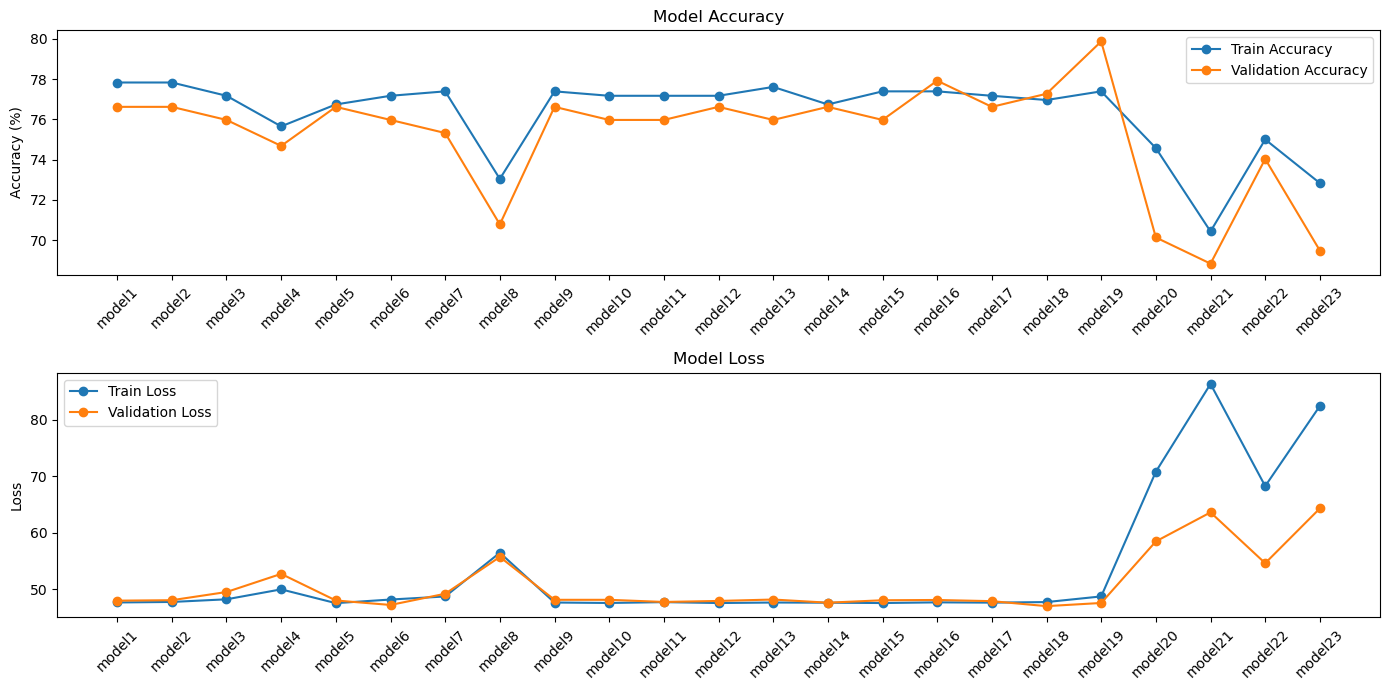

In [152]:
plot_model_performance(model_version, 
                       train_acc, 
                       val_acc, 
                       train_loss,
                       val_loss)

# evaluate best model

In [157]:
best_model = model18  # Assuming L2 model is the best
best_loss, best_accuracy= best_model.evaluate(X_test, y_test, batch_size=48, verbose=1)
print(f"Best Model - Test Loss: {best_loss}, Test Accuracy: {best_accuracy}")

3/3 [==============================] - 0s 3ms/step - loss: 0.4725 - accuracy: 0.7792
Best Model - Test Loss: 0.47245267033576965, Test Accuracy: 0.7792207598686218


5/5 [==============================] - 0s 3ms/step
Accuracy: 0.7792
Precision: 0.6731
Recall: 0.6731
F1-Score: 0.6731


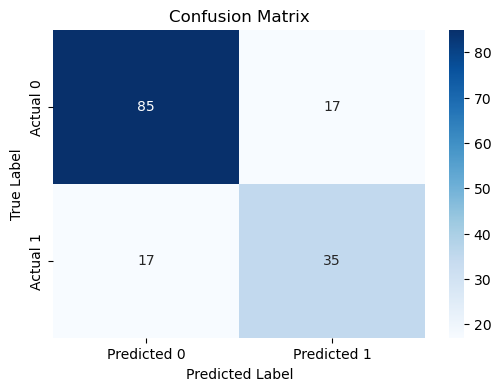

In [158]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict on validation data
y_test_pred = (best_model.predict(X_test) > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()